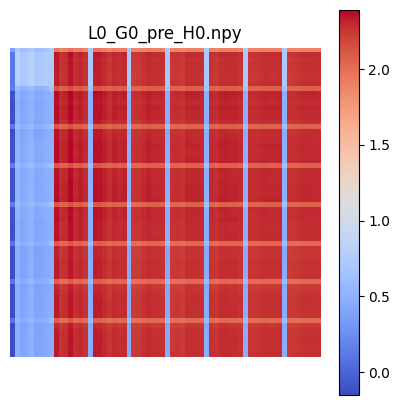

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def show_attention_heatmap(path, title=None):
    attn = np.load(path)

    plt.figure(figsize=(5, 5))
    plt.imshow(attn, cmap="coolwarm")
    plt.colorbar()
    plt.title(title if title else os.path.basename(path))
    plt.axis("off")
    plt.show()

# Example
show_attention_heatmap("attn_mats/L0_G0_pre_H0.npy")

In [27]:
def analyze_rank(attn, eps=1e-3):
    """
    attn: (tokens, tokens) numpy array
    eps: threshold for epsilon-rank
    """
    # SVD
    s = np.linalg.svd(attn, compute_uv=False)

    # ---- 1) epsilon rank (threshold relative to largest singular value)
    eps_rank = np.sum(s > eps * s[0])

    # ---- 2) condition number (ratio)
    cond = s[0] / s[-1] if s[-1] != 0 else np.inf

    # ---- 3) stable rank
    stable_rank = (np.sum(s**2) / (s[0]**2))

    # ---- 4) participation ratio (measure of spread)
    participation_ratio = (np.sum(s)**2) / np.sum(s**2)

    # ---- 5) true rank (machine precision)
    true_rank = np.linalg.matrix_rank(attn)

    return {
        "eps_rank": eps_rank.item(),
        "condition_number": cond.item(),
        "stable_rank": stable_rank.item(),
        "participation_ratio": participation_ratio.item(),
        "true_rank": true_rank.item()
    }

# Example
attn = np.load("attn_mats/L0_G0_pre_H0.npy")
analyze_rank(attn)


{'eps_rank': 3,
 'condition_number': 8.630195075656058e+24,
 'stable_rank': 1.000622034072876,
 'participation_ratio': 1.0604966878890991,
 'true_rank': 7}

In [88]:
import numpy as np
import pandas as pd
import glob
import re

def analyze_rank(attn, eps=1e-3):
    s = np.linalg.svd(attn, compute_uv=False)
    cond = s[0] / s[-1] if s[-1] != 0 else np.inf
    eps_rank = np.sum(s > eps * s[0])
    true_rank = np.linalg.matrix_rank(attn)
    return eps_rank, true_rank, cond

def parse_filename(fname):
    """
    Example filename:
    L0_G2_B0_pre_H3.npy  (or without B, depending on your format)
    We extract: L, G, pos, H
    """
    base = fname.split("/")[-1]
    
    # works for formats like:
    # L0_G0_pre_H1.npy
    # L2_G1_post_H5.npy
    m = re.match(r"L(\d+)_G(\d+)_([a-zA-Z]+)_H(\d+)\.npy", base)
    if m:
        L, G, pos, H = m.groups()
        return int(L), int(G), pos, int(H)
    else:
        raise ValueError(f"Filename format not recognized: {fname}")

def build_attention_dataframe(path="attn_mats/*.npy"):
    rows = []

    for fname in sorted(glob.glob(path)):
        # parse filename meta-data
        L, G, pos, H = parse_filename(fname)

        # load matrix
        attn = np.load(fname)

        # compute ranks
        eps_rank, true_rank, cond = analyze_rank(attn)

        # append record
        rows.append({
            "Layer": L,
            "Group": G,
            "Head": H,
            "Pos": pos,
            "EpsRank": eps_rank,
            "TrueRank": true_rank,
            # "condition": cond
        })

    df = pd.DataFrame(rows)
    return df

df_attn = build_attention_dataframe()
df_attn.head()

,Layer,Group,Head,Pos,EpsRank,TrueRank
0,0,0,0,mid,58,64
1,0,0,1,mid,63,64
2,0,0,2,mid,38,64
3,0,0,3,mid,64,64
4,0,0,4,mid,64,64


In [56]:
df_attn[['EpsRank', 'TrueRank']].describe()

,EpsRank,TrueRank
count,648.000000,648.000000
mean,44.742284,51.537037
std,21.876284,17.854431
min,1.000000,6.000000
25%,24.000000,30.000000
50%,59.000000,64.000000
75%,62.000000,64.000000
max,64.000000,64.000000


In [80]:
df_attn.groupby("Pos")[["EpsRank", "TrueRank"]].mean()

,EpsRank,TrueRank
Pos,,
mid,56.342593,63.907407
post,60.916667,63.902778
pre,16.967593,26.800926


In [89]:
pivot = pd.pivot_table(
    df_attn,
    values=["EpsRank", "TrueRank"],
    index=["Layer"],
    columns=["Pos"],
    aggfunc="mean"
)
pivot

EpsRank                         TrueRank                      
Pos          mid       post        pre        mid       post        pre
Layer                                                                  
0      59.361111  62.305556   7.666667  63.916667  64.000000  18.416667
1      61.916667  61.138889  21.083333  64.000000  64.000000  29.916667
2      61.305556  62.388889  25.472222  63.972222  63.972222  30.000000
3      60.055556  62.472222  25.416667  63.944444  63.944444  30.000000
4      53.805556  62.027778  17.750000  63.833333  63.944444  30.000000
5      41.611111  55.166667   4.416667  63.777778  63.555556  22.472222

    Pre Rank (QKt) is very less, with first and last layers having extremely small values like 7, 4
    Mid Rank (Qkt + PB) is huge compared to pre rank, positional bias is the one mainly increasing the rank
    Post Rank (softmax(QKt + PB)) is almost ~64 in every layer showing exponential amplifying the distance between values